## 9.1. Example: Wrangling CO2 Measurements from Mauna Loa Observatory

Carbon dioxide (CO2) is an important signal of global warming. CO2 is a gas that traps heat in the earth’s atmosphere. Without it, earth would be impossibly cold, but increases in CO2 also drives global warming and threatens our planet’s climate. CO2 concentrations have been monitored at Mauna Loa Observatory since 1958, and these data offer a crucial benchmark for understanding the threat of global warming.

In this example, we introduce the concepts of data wrangling: data-quality checks, handling missing values, feature transformations, and table reshaping. These data are in the file ```data/co2_mm_mlo.txt```. Let’s begin by checking the formatting, encoding, and size of the source before we load it into a data frame.

In [28]:
from pathlib import Path
import os
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

co2_file = Path('data') / 'co2_mm_mlo.txt'

print(f'File size: {os.path.getsize(co2_file) / 1024:0.2f} KiB')

encoding = chardet.detect(co2_file.read_bytes())['encoding']
print(f'File encoding: {encoding}')

File size: 49.93 KiB
File encoding: ascii


We have found that the file is plain text with ASCII encoding and about 50 KiB. Since the file is not particularly large, we shouldn’t have any difficulty loading it into a data frame, but we first need to determine the file’s format. To do this, let’s look at the first few lines in the file.

In [9]:
lines = co2_file.read_text().split('\n')
len(lines)

811

In [10]:
lines[:6]

['# --------------------------------------------------------------------',
 '# USE OF NOAA ESRL DATA',
 '# ',
 '# These data are made freely available to the public and the',
 '# scientific community in the belief that their wide dissemination',
 '# will lead to greater understanding and new scientific insights.']

We see that the file begins with information about the data source. We should read this documentation before starting our analysis, but some times the urge to plunge into the analysis wins over and we just start mucking about and discover properties of the data as we go. So let’s quickly find where the actual data values are located.

In [11]:
lines[69:79]

['#',
 '#            decimal     average   interpolated    trend    #days',
 '#             date                             (season corr)',
 '1958   3    1958.208      315.71      315.71      314.62     -1',
 '1958   4    1958.292      317.45      317.45      315.29     -1',
 '1958   5    1958.375      317.50      317.50      314.71     -1',
 '1958   6    1958.458      -99.99      317.10      314.85     -1',
 '1958   7    1958.542      315.86      315.86      314.98     -1',
 '1958   8    1958.625      314.93      314.93      315.94     -1',
 '1958   9    1958.708      313.20      313.20      315.91     -1']

We have found the data begins on the 73rd line of the file. We also spot some relevant characteristics:

1. The values are separated by white space, possibly tabs.

2. The data line up down the rows. For example, the month appears in 7th to 8th position of each line.

3. The 71st and 72nd lines in the file contain column headings split over two lines.

We can use read_csv to read the data into a Pandas data frame, and we provide arguments to specify that the separators are white space, there is no header (we will set our own column names), and to skip the first 72 rows of the file.

In [12]:
co2 = pd.read_csv('data/co2_mm_mlo.txt', header=None, skiprows=72, 
                  sep='\s+',
                  names=['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'days'])
co2

,Yr,Mo,DecDate,Avg,Int,Trend,days
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1
...,...,...,...,...,...,...,...
733,2019,4,2019.292,413.32,413.32,410.49,26
734,2019,5,2019.375,414.66,414.66,411.20,28
735,2019,6,2019.458,413.92,413.92,411.58,27
736,2019,7,2019.542,411.77,411.77,411.43,23


### 9.1.1. Quality Checks

Since scientific studies tend to have very clean data, let’s jump right in and make a time series plot of CO2 monthly averages.

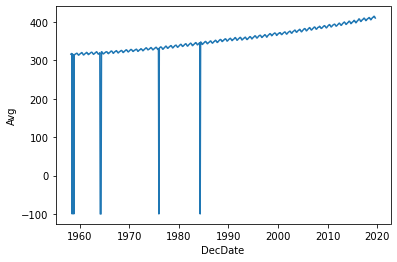

In [15]:
sns.lineplot(x='DecDate', y='Avg', data=co2);

Yikes! Plotting the data uncovered a problem. What happened here? We can check a few rows of the dataframe to see if we can spot issues in the data.



In [16]:
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,days
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1


In [17]:
co2.tail()

,Yr,Mo,DecDate,Avg,Int,Trend,days
733,2019,4,2019.292,413.32,413.32,410.49,26
734,2019,5,2019.375,414.66,414.66,411.20,28
735,2019,6,2019.458,413.92,413.92,411.58,27
736,2019,7,2019.542,411.77,411.77,411.43,23
737,2019,8,2019.625,409.95,409.95,411.84,29


Looking a bit more closely this time, we see that some data have unusual values like -1 and -99.99. When we read the information at the top of the file more carefully, we find that -99.99 denotes a missing monthly average and -1 signifies a missing value for the number of days the equipment was in operation that month.

et’s step back and perform some quality checks. First, we consider the shape of the data. How many rows should we have? From looking at the head and tail of the data frame, the data appear to be in chronological order, beginning with March 1958 and ending with August 2019. This means we should have 12×(2019−1957)−2−4=738 records.

In [18]:
co2.shape

(738, 7)

Our calculations match the number of rows. Next, let’s go on to check the quality of the features, starting with Mo. We expect the values to range from 1 to 12, and each month should have 2019-1957 = 62 or 61 instances (since the recordings begin in March of the first year and end in August of the most recent year).

In [19]:
co2["Mo"].value_counts().reindex(range(1,13))

1     61
2     61
3     62
4     62
5     62
6     62
7     62
8     62
9     61
10    61
11    61
12    61
Name: Mo, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

Let’s turn to examine ```days```.

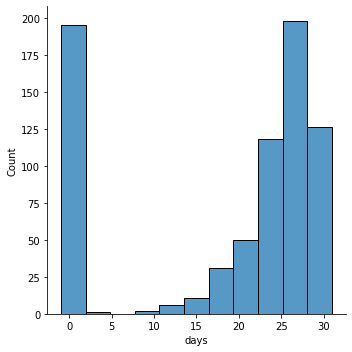

In [21]:
sns.displot(co2['days']);

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values. Let’s check to see if there is any connection between missingness and the year of the recording.



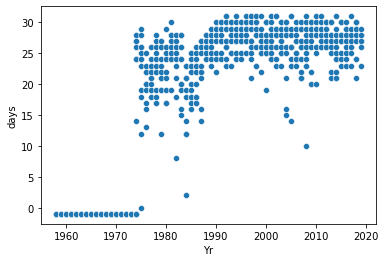

In [22]:
sns.scatterplot(x="Yr", y="days", data=co2);

All of the missing data are in the early years of operation. The number of days of operation of the equipment may no longer be available for the early days of operation. It also appears that there might have been problems with the equipment in the mid to late 80s. What do we do with these conjectures? We would want to confirm them by looking through documentation about the historical readings. If we are concerned about the impact on the CO2 averages of the missing values for days, then a simple solution would be to drop the earliest recordings. However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

Next, let’s return to the -99.99 values in Avg and the overall quality of the CO2 measurements.

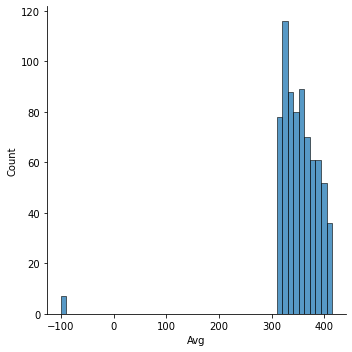

In [23]:
sns.displot(co2['Avg']);

The non-missing values are in the 300-400 range, which is as expected based on our external research on CO2 levels. We also see that there are only a few missing values. Since there aren’t many missing values, we can examine all of them:

In [24]:
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,days
3,1958,6,1958.458,-99.99,317.10,314.85,-1
7,1958,10,1958.792,-99.99,312.66,315.61,-1
71,1964,2,1964.125,-99.99,320.07,319.61,-1
72,1964,3,1964.208,-99.99,320.73,319.55,-1
73,1964,4,1964.292,-99.99,321.77,319.48,-1
213,1975,12,1975.958,-99.99,330.59,331.60,0
313,1984,4,1984.292,-99.99,346.84,344.27,2


### 9.1.2. Addressing Missing Data


What do we do with the -99.99s that we have discovered? Do we drop those records? Do we replace -99.99 with NaN? Or substitute it with a likely value for the average CO2? What do you think are the pros and cons of each possible action? Let’s examine each of these three options. We make two versions of the data, one that drops records and the other that replaces -99.99 with NaN.

In [26]:
# Dropped missing values
co2_drop = co2[co2['Avg'] > 0]

# Replaced with NaN
co2_NA = co2.replace(-99.99, np.NaN)

We’ll also use a third version of the data. First, we note that the dataset already comes with a substitute value for the -99.99. The Int feature has values that exactly match those in ```Avg```, except when ```Avg``` is -99.99, and then a “reasonable” estimate is used instead. So, the third version of our data will use the ```Int``` feature instead of ```Avg```.

We’ll discuss what we mean by reasonable in a moment. For now, let’s zoom in on a short time period, say the measurements in 1958, where we know we have two missing values. Next, we’ll create a time series plot for the three cases: drop the records with -99.99s (left plot); use NaN for missing value (middle plot); substitute an estimate for -99.99 (right plot).

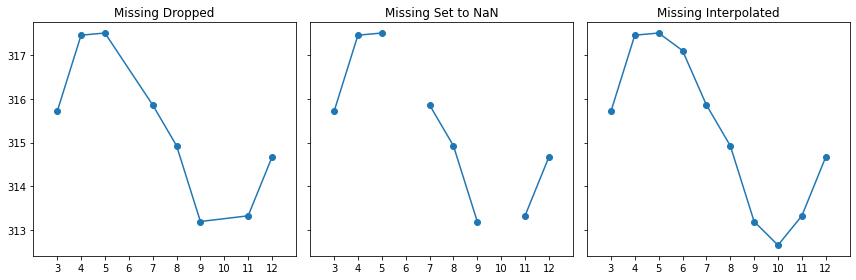

In [29]:
def line_and_points(data, ax, y='Avg', title="Missing Dropped"):
    ax.plot('Mo', y, data=data)
    ax.scatter('Mo', y, data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

line_and_points(co2_drop[:8], axes[0])
line_and_points(co2_NA[:10], axes[1], title="Missing Set to NaN")
line_and_points(co2_NA[:10], axes[2], y='Int', title="Missing Interpolated")

plt.tight_layout()

Can you see what’s happening in each of these plots? The leftmost plot connects dots over a two month time period, rather than one month. In the middle, the line breaks where the data are missing, and on the right, we can see two monthly averages have been added. In the big picture since there are only seven values missing from the 738 months, any of these options works. However, there is some appeal to the right plot since the seasonal trends are more cleanly discernible.

The method used to interpolate the CO2 measurements for the missing values uses an averaging process that takes into consideration the month and year. The idea is to reflect both seasonal changes and the long term trend. This technique is described in greater detail in the documentation at the top of the data file. We will opt for the third option and use the average values provided by NOAA.

### 9.1.3. Reshaping the Data Table

We determined earlier that each row of the data table represents a month. But the actual measurements from the research station happen more frequently. In fact, the GML website has datasets for daily and hourly measurements too. You might see some asymmetry in the granularity. We can go from hourly recordings to daily averages but not the other way around. The hourly data has a finer granularity than the daily data; reciprocally, the daily data has a coarser granularity than the hourly data. We use aggregation to go to a coarser granularity — in pandas, we would use .groupby() and .agg().

Why not always just use the data with the finest granularity available? On a computational level, very fine-grained data can become very large. The Mauna Loa Observatory started recording CO2 levels in 1958. Imagine how many rows the data table would contain if they took measurements every single second! But more importantly, you want the granularity of the data to match your research question. Suppose you want to see whether CO2 levels have risen over the past 50+ years, consistent with global warming predictions. You don’t need a CO2 measurement every second. In fact, you might well be content with yearly data where the seasonal patterns are smoothed away. We can aggregate the data, changing its granularity to annual average measurements, and make a plot to display the trend.

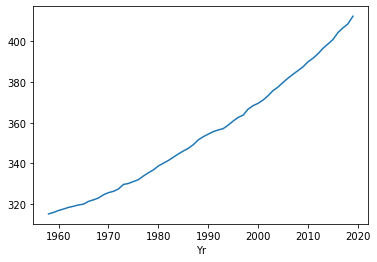

In [30]:
co2_NA.groupby('Yr')['Int'].mean().plot();

Indeed, we see a rise by nearly 100 ppm of CO2 since Mauna Loa began recording in 1958.



### 9.1.4. Takeaways

After reading the whitespace-separated, plain-text file into a data frame, we began to check its quality. We used the scope and context of the data to affirm that its shape matched the range of dates of collection. We confirmed the values and counts for the month were as expected. We ascertained the extent of missing values in the features, and looked for connections between missing values and other features. We considered three approaches to handling the missing data: drop records, work with NaN values, and impute values to have a full table. And, finally, we changed the granularity of the data frame (Section 8.5) by rolling it up from a monthly to an annual average. This change in granularity removed seasonal fluctuations, which focussed on the long term trend in the level of CO2 in the atmosphere. The next four sections expand on these actions to wrangle the data into a form suitable for analysis: quality checks, missing value treatments, transformations, and shape adjustments. We begin with quality checks.